# Adaptive PCE

This notebook is an example of UncertainSCI's functionality to adaptively determine the needed polynomial order of a given model and parameter set.  This example is equivalent to `demos/adapt_pce.py`


In [1]:
from itertools import chain, combinations

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation

from UncertainSCI.distributions import BetaDistribution
from UncertainSCI.model_examples import KLE_exponential_covariance_1d, \
                                        laplace_ode, laplace_grid_x
from UncertainSCI.indexing import TotalDegreeSet
from UncertainSCI.pce import PolynomialChaosExpansion
from UncertainSCI.utils.version import version_lessthan

# some features work better with this option
%matplotlib notebook

## Adaptive PCE Setup

Three things must be specified:
- The physical model
- A parameter distribution
- The initial expressivity of the PCE (polynomial space)




### Define Forward model

The model in this example is a 1D laplacian ODE.  See the `laplace_ode_1d` [method](../models.html) or `UncertainSCI/model_examples.py` for details.

$$
-\frac{d}{dx} a(x,p) \cdot \frac{d}{dx} u(x,p) = f(x)
$$

over $x$ in $[-1,1]$, where $a(x,p)$ is a parameterized diffusion model:

$$
a(x,p) = \bar{x} + \sum_{j=1}^d \lambda_j p_j \phi_j(x)
$$

where $d$ is the dimension, ($\lambda_j$, $\phi_j$) are eigenpairs of the exponential
covariance kernel,

$$
K(s,t) = e^{-|s-t|/a}.
$$

The $p_j$ are modeled as random variables.



In [2]:
# Number of parameters
dimension = 2

# Define diffusion coefficient
a = 1.
b = 1.  # Interval is [-b,b]
abar = lambda x: 1*np.ones(np.shape(x))
KLE = KLE_exponential_covariance_1d(dimension, a, b, abar)

diffusion = lambda x, p: KLE(x, p)

N = int(1e2)  # Number of spatial degrees of freedom of model
left = -1.
right = 1.
x = laplace_grid_x(left, right, N)

model = laplace_ode(left=left, right=right, N=N, diffusion=diffusion)


### Parameter Distributions

We are using two model parameters with the same beta distribution for this example. 

In [3]:


# Specifies 1D distribution on [0,1] (alpha=beta=1 ---> uniform)
alpha = 1.
beta = 1.
dist = BetaDistribution(alpha=alpha, beta=beta, dim=dimension)

### Initial Expressivity of the PCE

This example uses a different setup than you might see in [other examples](./build_pce.html).  Other setups will be equivalent for many non-adaptive cases, but it is useful to operate with the index set in this example.  Another important distinction that is necessary for the adaptive case is supplying the model as a lambda function to the PCE object.  

In [4]:
# Expressivity setup
order = 0
index_set = TotalDegreeSet(dim=dimension, order=order)
starting_indices = index_set.get_indices()

In [5]:
# Building the PCE
pce = PolynomialChaosExpansion(index_set, dist)
pce.build(model=model)
Nstarting_samples = pce.samples.shape[0]
initial_accuracy = pce.accuracy_metrics.copy()

## Running Adaptive PCE

With the initial PCE setup, we can run adaptive method.  This will attempt to find the best order to represent the uncertainty for the given model and parameter distributions.  The method will add new samples as needed to minimize the residual error between iterations.  This may take a few minutes to run from scratch.  

In [39]:
# pce.adapt_robustness(max_new_samples=50)
residuals, loocvs, added_indices, added_samples = pce.adapt_expressivity(max_new_samples=100, add_rule=3)


new indices:      1,   new samples:      4
old residual: 1.418e-09,  old loocv: 4.334e-06
new residual: 1.424e-09,  new loocv: 4.259e-06
new indices:      1,   new samples:      4
old residual: 1.424e-09,  old loocv: 4.259e-06
new residual: 1.446e-09,  new loocv: 4.243e-06
new indices:      1,   new samples:      4
old residual: 1.446e-09,  old loocv: 4.243e-06
new residual: 9.789e-10,  new loocv: 2.748e-06
new indices:      1,   new samples:      4
old residual: 9.789e-10,  old loocv: 2.748e-06
new residual: 9.637e-10,  new loocv: 2.499e-06
new indices:      1,   new samples:      4
old residual: 9.637e-10,  old loocv: 2.499e-06
new residual: 6.000e-10,  new loocv: 2.085e-06
new indices:      1,   new samples:      4
old residual: 6.000e-10,  old loocv: 2.085e-06
new residual: 2.177e-10,  new loocv: 1.412e-06
new indices:      1,   new samples:      4
old residual: 2.177e-10,  old loocv: 1.412e-06
new residual: 9.205e-11,  new loocv: 9.741e-07
new indices:      1,   new samples:      

## Output Statistics

With the optimal polynomial order determined, computing the output statistics is as straightforward as other examples. 

In [40]:
# # Postprocess PCE: mean, stdev, sensitivities, quantiles
mean = pce.mean()
stdev = pce.stdev()


In [41]:
# Set of subsets of [0, 1, ..., dimension-1] with at most 3 components
variable_interactions = list(chain.from_iterable(combinations(range(dimension), r) for r in range(1, 3+1)))


In [42]:
# "Total sensitivity" is a non-partitive relative sensitivity measure per
# parameter.
total_sensitivity = pce.total_sensitivity()


In [43]:
# "Global sensitivity" is a partitive relative sensitivity measure per set of
# parameters.
global_sensitivity = pce.global_sensitivity(variable_interactions)

In [44]:
# Quantile bands, similar to a box plot
# used for PCE and MC
Q = 3  # Number of quantile bands to plot
dq = 0.5/(Q+1)
q_lower = np.arange(dq, 0.5-1e-7, dq)[::-1]
q_upper = np.arange(0.5 + dq, 1.0-1e-7, dq)
quantile_levels = np.append(np.concatenate((q_lower, q_upper)), 0.5)

## Monte Carlo Statistics

Here we compute the output statistics using Monte Carlo (MC) sampling to compare to the adaptive PCE method.

In [45]:
# # For comparison: Monte Carlo statistics
M = 1000  # Generate MC samples
p_phys = dist.MC_samples(M)
output = np.zeros([M, N])

for j in range(M):
    output[j, :] = model(p_phys[j, :])

MC_mean = np.mean(output, axis=0)
MC_stdev = np.std(output, axis=0)
if version_lessthan(np,'1.15'):
    from scipy.stats.mstats import mquantiles
    MC_quantiles = mquantiles(output, quantile_levels, axis=0)
else:
    MC_quantiles = np.quantile(output, quantile_levels, axis=0)
MC_median = MC_quantiles[-1, :]

## Visualize Statistics

Similar to [other examples](./build_pce.html), we will plot the uncertainty over the domain of the domain of the model.  This example shows how users might do so more manually instead of using the [built in plotting functions](./build_pce.html#output-visualizations)

### Plotting Setup

To plot our output statistics we are going to compute the quantile bands that we will visualize

In [46]:

quantiles = pce.quantile(quantile_levels, M=int(2e3))
median = quantiles[-1, :]

### Single Domain Plot Comparison

Plotting the mean and standard deviation for both PCE and MC.  Each are plotted a different way to help differentiate them.  

In [49]:
# # Visualization
V = 50  # Number of MC samples to visualize

# mean +/- stdev plot
plt.plot(x, output[:V, :].T, 'k', alpha=0.8, linewidth=0.2)
plt.plot(x, mean, 'b', label='PCE mean')
plt.fill_between(x, mean-stdev, mean+stdev, interpolate=True, facecolor='red',
                 alpha=0.5, label='PCE 1 stdev range')

plt.plot(x, MC_mean, 'b:', label='MC mean')
plt.plot(x, MC_mean+MC_stdev, 'r:', label='MC mean $\\pm$ stdev')
plt.plot(x, MC_mean-MC_stdev, 'r:')

plt.xlabel('x')
plt.title('Mean $\\pm$ standard deviation')

plt.legend(loc='lower right')


### Side-by-Side Domain Plot Comparison

Here we plot similar data to the previous figure, but with two plots to allow the quantile bands to be shown for each method.  

<IPython.core.display.Javascript object>


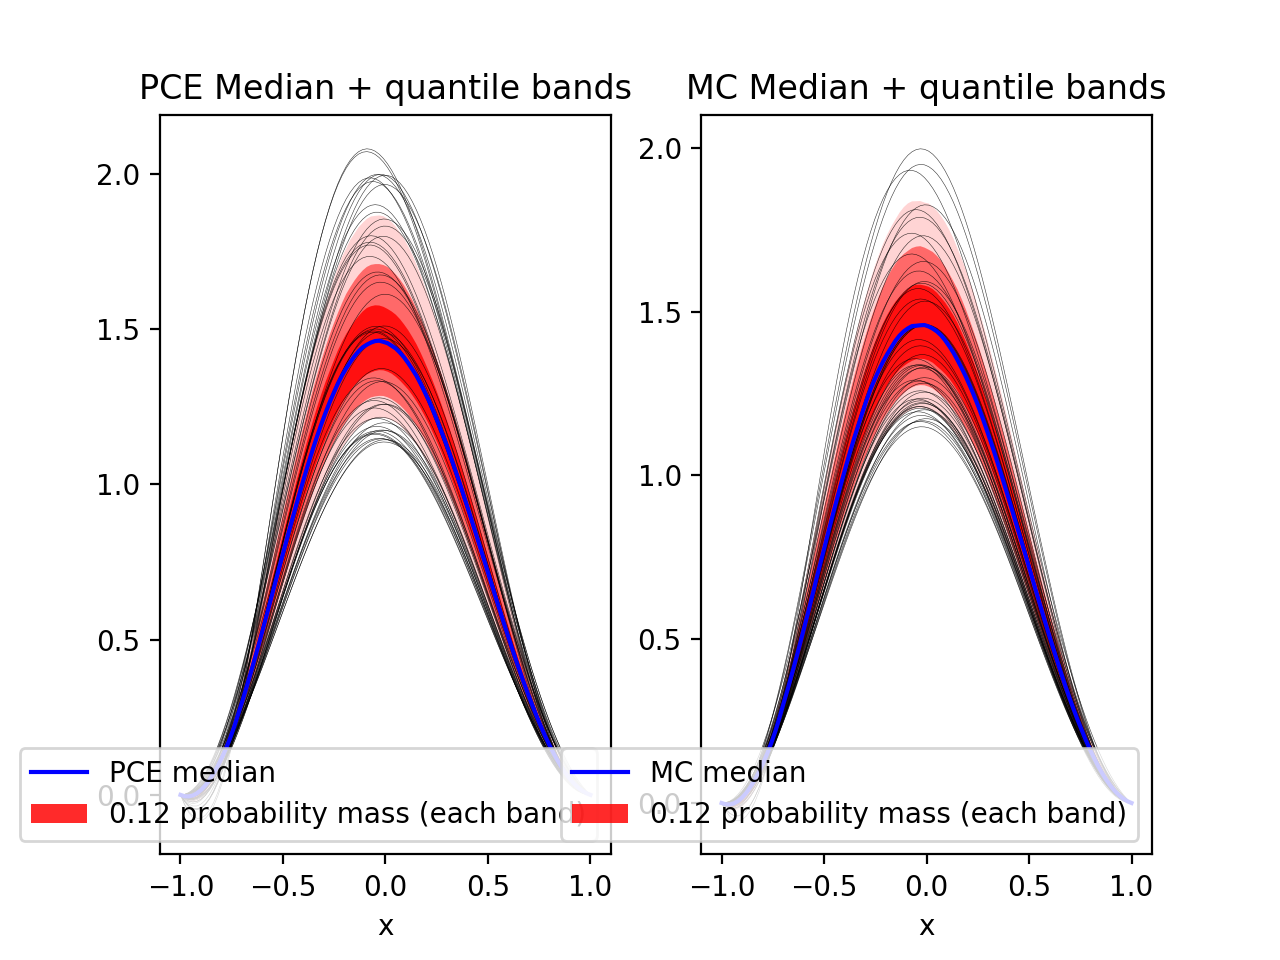

In [50]:
# quantile plot
plt.figure()


plt.subplot(121)
plt.plot(x, pce.model_output[:V, :].T, 'k', alpha=0.8, linewidth=0.2)
plt.plot(x, median, 'b', label='PCE median')

band_mass = 1/(2*(Q+1))

for ind in range(Q):
    alpha = (Q-ind) * 1/Q - (1/(2*Q))
    if ind == 0:
        plt.fill_between(x, quantiles[ind, :], quantiles[Q+ind, :],
                         interpolate=True, facecolor='red', alpha=alpha,
                         label='{0:1.2f} probability mass (each band)'.format(band_mass))
    else:
        plt.fill_between(x, quantiles[ind, :], quantiles[Q+ind, :],
                         interpolate=True, facecolor='red', alpha=alpha)

plt.title('PCE Median + quantile bands')
plt.xlabel('x')
plt.legend(loc='lower right')

plt.subplot(122)
plt.plot(x, output[:V, :].T, 'k', alpha=0.8, linewidth=0.2)
plt.plot(x, MC_median, 'b', label='MC median')

for ind in range(Q):
    alpha = (Q-ind) * 1/Q - (1/(2*Q))
    if ind == 0:
        plt.fill_between(x, MC_quantiles[ind, :], MC_quantiles[Q+ind, :],
                         interpolate=True, facecolor='red',
                         alpha=alpha,
                         label='{0:1.2f} probability mass (each band)'
                         .format(band_mass))
    else:
        plt.fill_between(x, MC_quantiles[ind, :], MC_quantiles[Q+ind, :],
                         interpolate=True, facecolor='red', alpha=alpha)

plt.title('MC Median + quantile bands')
plt.xlabel('x')
plt.legend(loc='lower right')


### Parameter Sensitivity Estimated with PCE

The pie chart shows the global sensitivity of the model to each parameter averaged over the domain.  Global sensitivities can help differentiate model sensitivity from a single parameter and parameter interactions. 

<IPython.core.display.Javascript object>


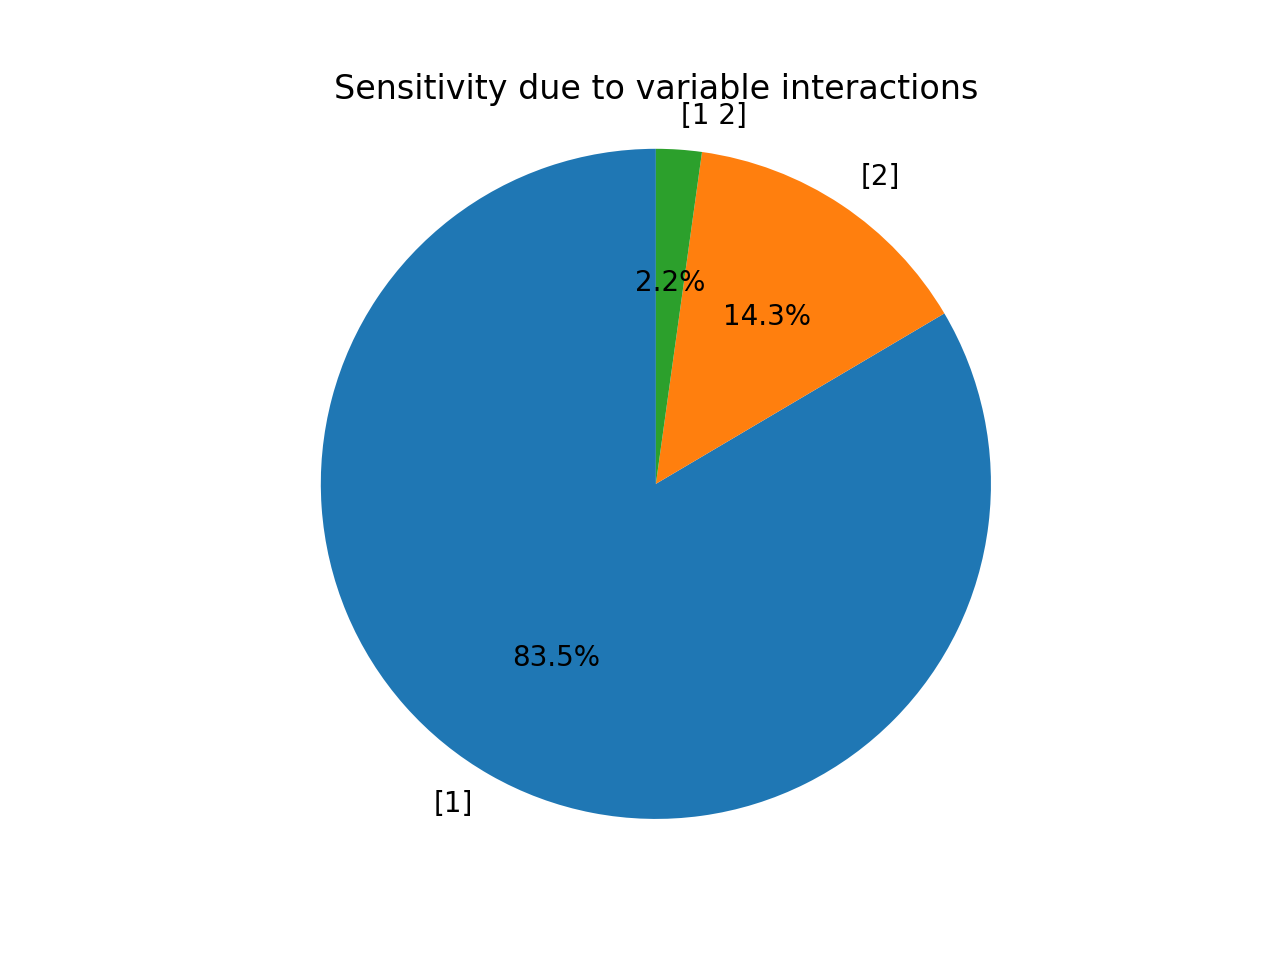

Text(0.5, 1.0, 'Sensitivity due to variable interactions')

In [51]:
# Sensitivity pie chart, averaged over all model degrees of freedom
average_global_SI = np.sum(global_sensitivity, axis=1)/N

labels = ['[' + ' '.join(str(elem) for elem in [i+1 for i in item]) +
          ']' for item in variable_interactions]
_, ax = plt.subplots()
ax.pie(average_global_SI*100, labels=labels, autopct='%1.1f%%',
       startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Sensitivity due to variable interactions')



### Regression Plots

The regression plots in this section help illustrate the choices of the adaptive PCE method.  

<IPython.core.display.Javascript object>


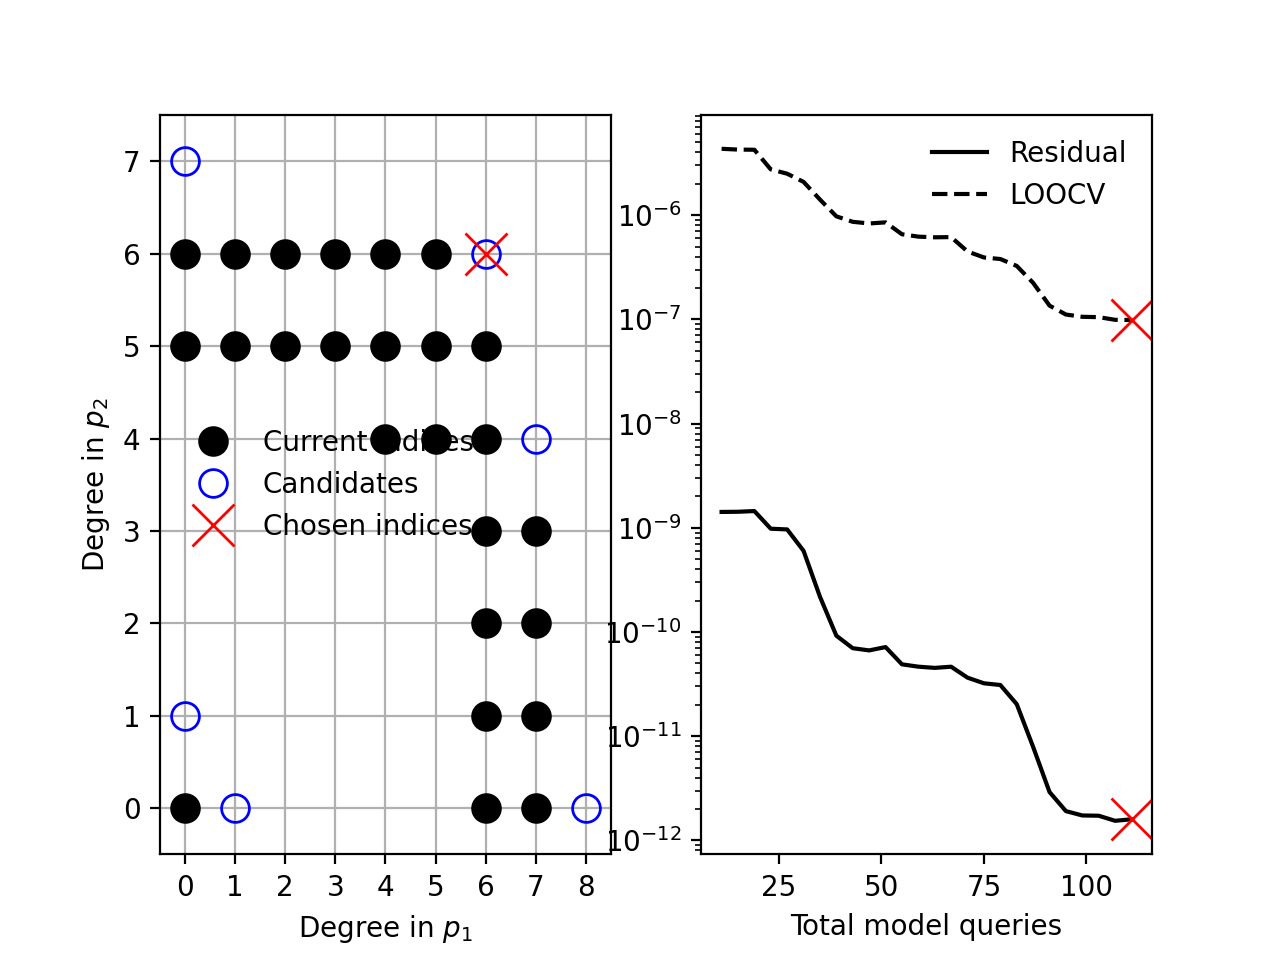

In [56]:
# Index set plot
fig = plt.figure()

plt.subplot(121)

current_inds = plt.plot(starting_indices[:, 0], starting_indices[:, 1],
                        'k.', markersize=20, label='Current indices')[0]
rmargin = plt.plot([], [], 'bo', markersize=10, fillstyle='none',
                   label='Candidates')[0]
future_inds = plt.plot([], [], 'rx', markersize=15,
                       label='Chosen indices')[0]

plt.legend(frameon=False)

indices = pce.index_set.get_indices()
maxx, maxy = indices[:, 0].max(), indices[:, 1].max()
plt.axis([-0.5, maxx+1.5, -0.5, maxy+1.5])
plt.gca().set_yticks(range(maxy+2), minor=False)
plt.gca().set_xticks(range(maxx+2), minor=False)
plt.grid()
plt.xlabel('Degree in $p_1$')
plt.ylabel('Degree in $p_2$')

plt.subplot(122)
added_samples_plt = added_samples[:] # shallow copy
added_samples_plt.insert(0, Nstarting_samples)
Nsamples = np.cumsum(added_samples_plt)

plt.semilogy(Nsamples, residuals, 'k-', label='Residual')
plt.semilogy(Nsamples, loocvs, 'k--', label='LOOCV')
current_accuracy = plt.plot([], [], 'rx', markersize=15)[0]
plt.xlabel('Total model queries')
plt.legend(frameon=False)

def animation_init():
    return current_inds, future_inds, rmargin, current_accuracy

def animation_update(i):
    index_set = TotalDegreeSet(dim=dimension, order=order)
    for q in range(i):
        index_set.augment(added_indices[q])

    current_set = index_set.get_indices()
    reduced_margin = index_set.get_reduced_margin()

    current_inds.set_data(current_set[:, 0], current_set[:, 1])
    rmargin.set_data(reduced_margin[:, 0], reduced_margin[:, 1])
    future_inds.set_data(added_indices[i][:, 0], added_indices[i][:, 1])
    current_accuracy.set_data([Nsamples[i+1], Nsamples[i+1]],
                              [residuals[i+1], loocvs[i+1]])

    return current_inds, future_inds, rmargin, current_accuracy

ani = animation.FuncAnimation(fig, animation_update,
                              np.arange(0, len(added_indices)),
                              interval=500, blit=True,
                              init_func=animation_init, repeat=False)


    